[PAIR] dspl: clean vs noisy | params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | clean N=6000 | noisy N=6000


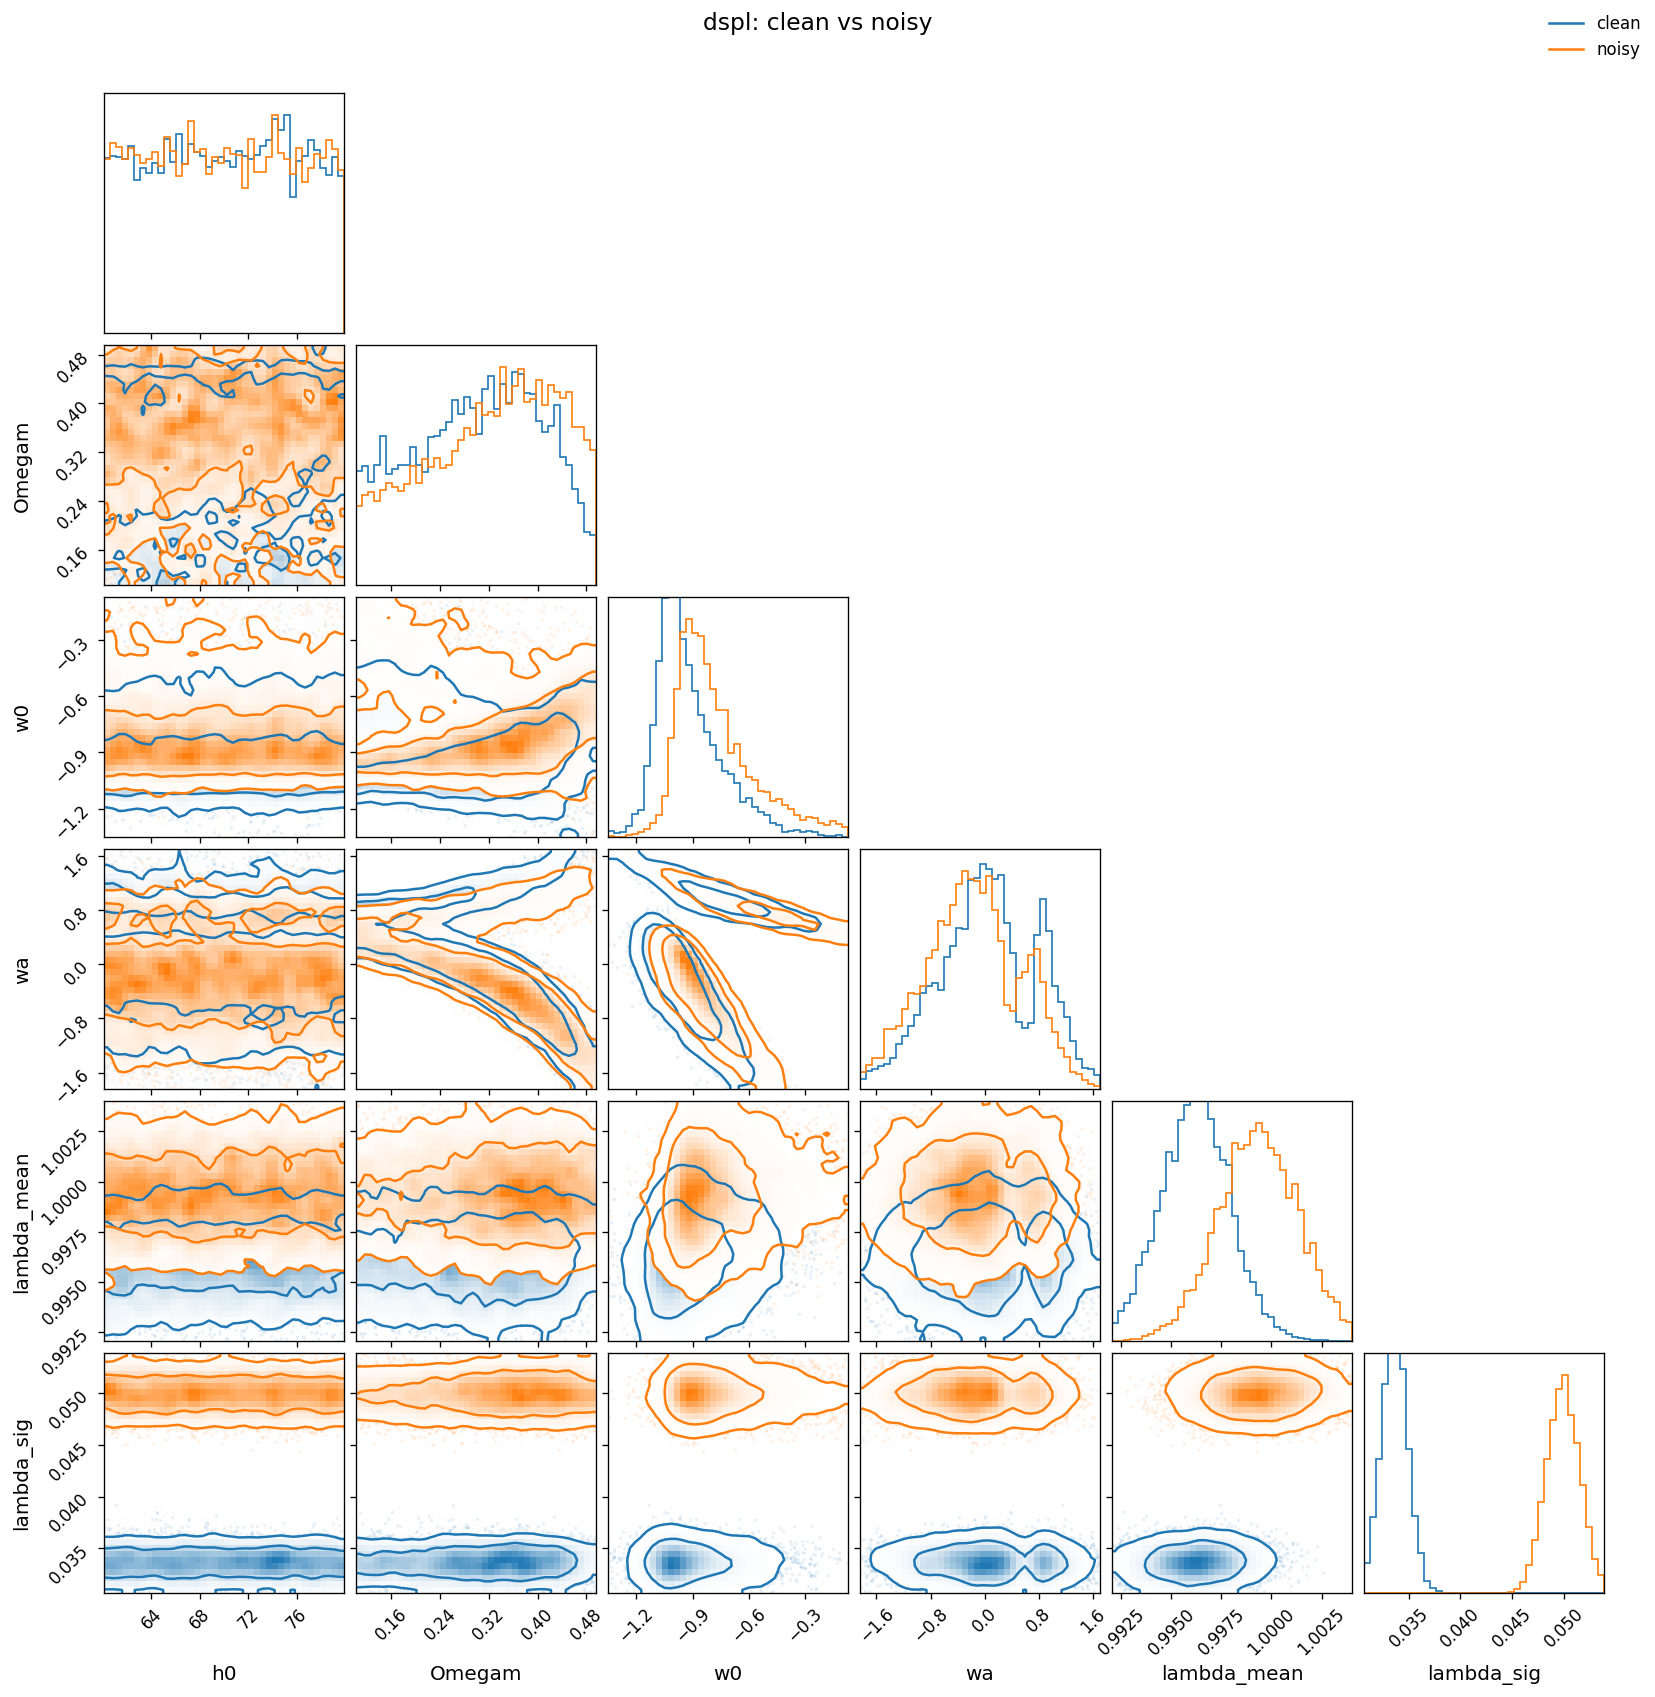

[PAIR] lens_kin: clean vs noisy | params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | clean N=6000 | noisy N=6000


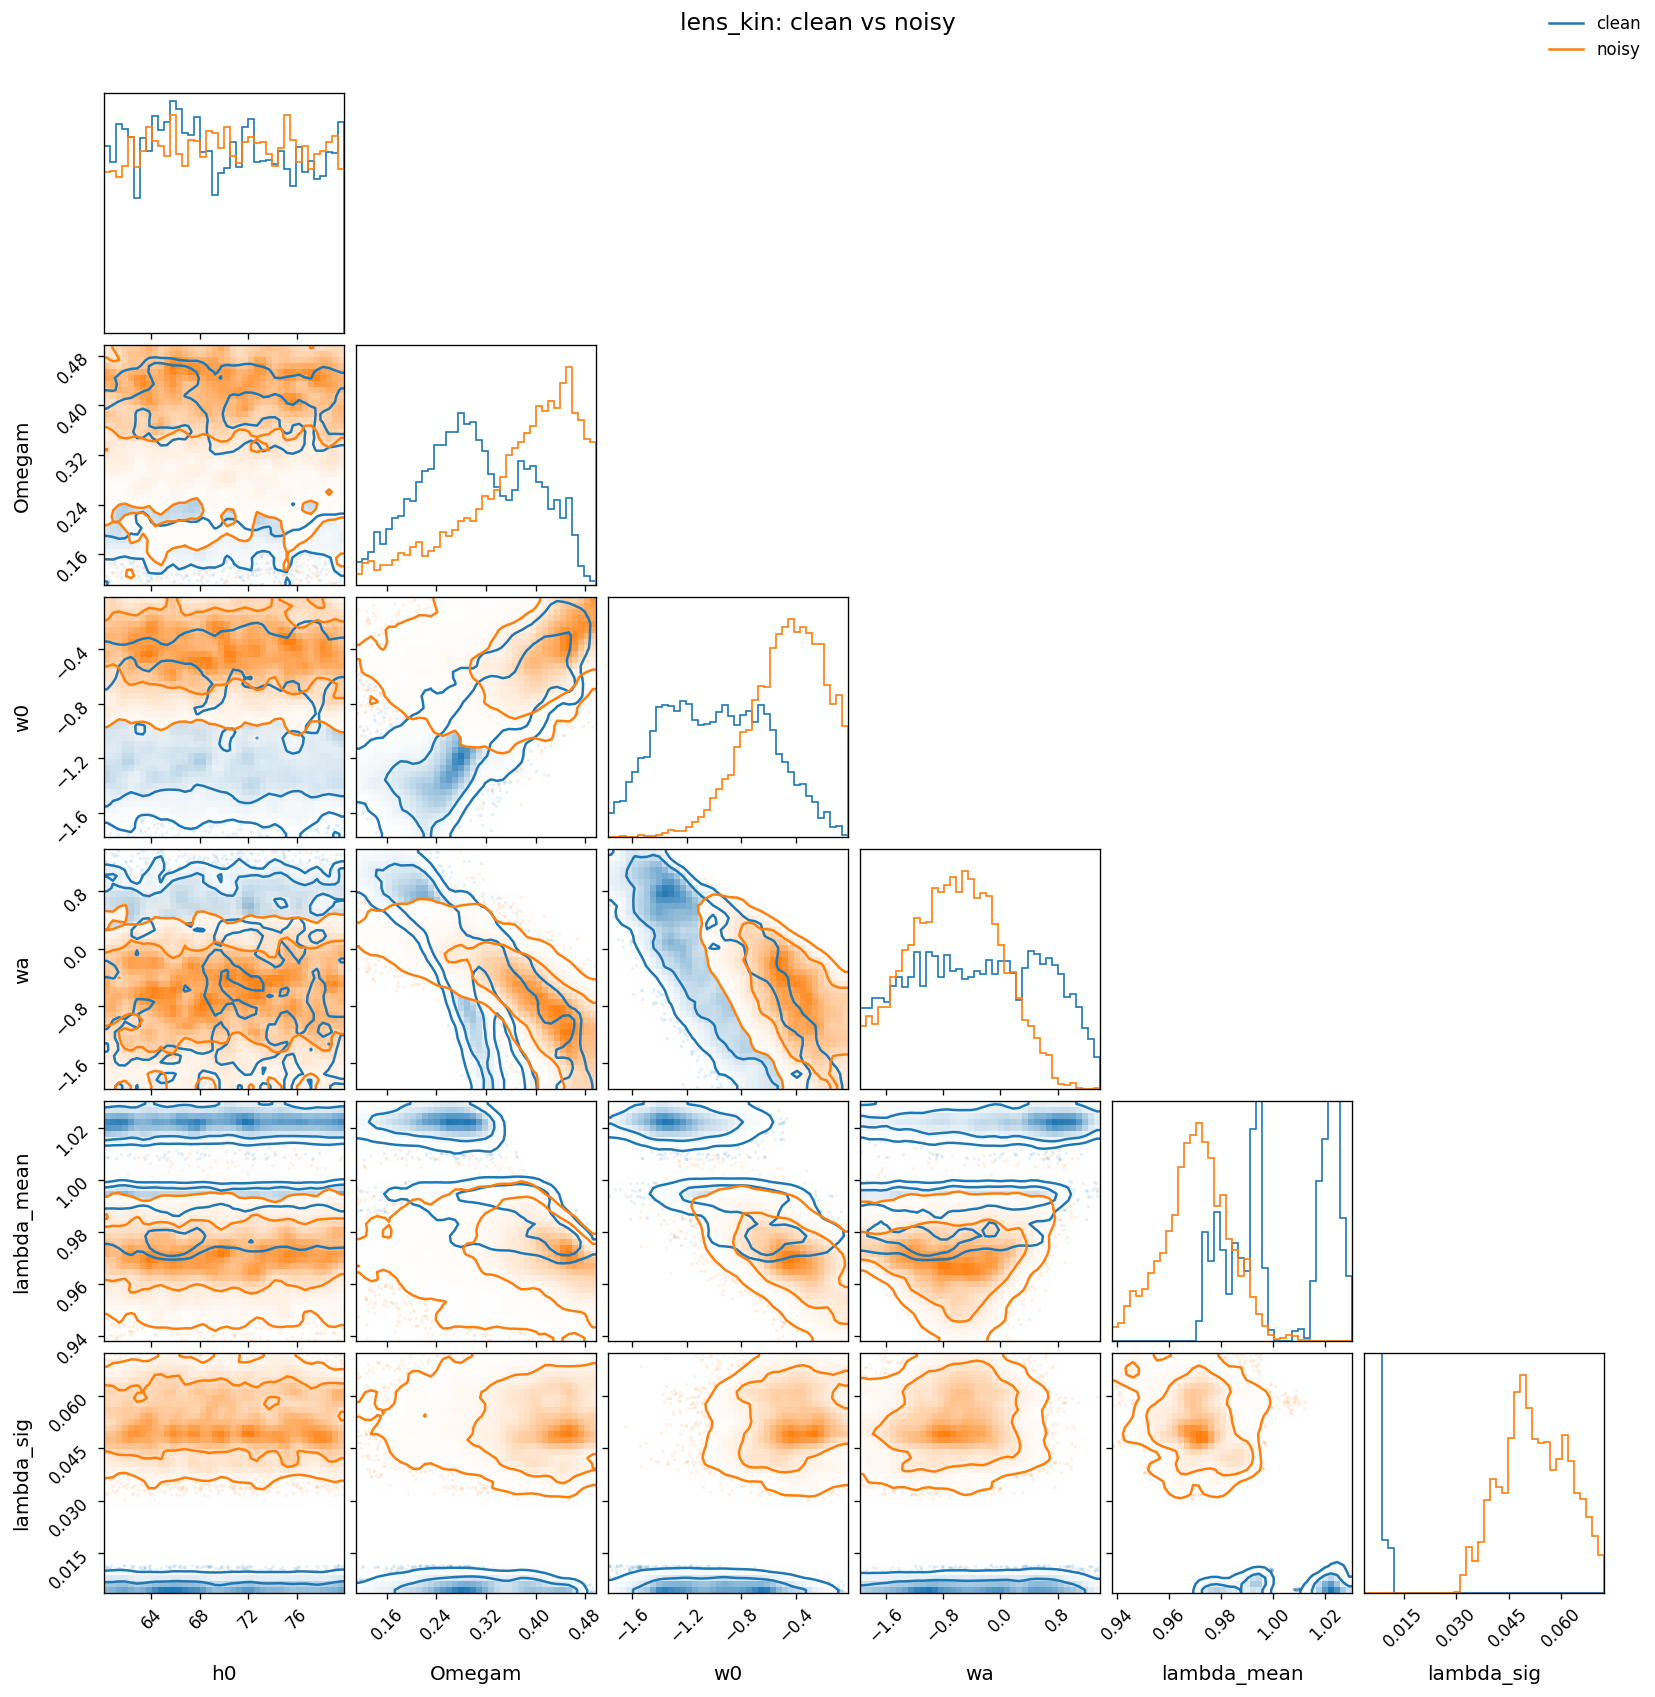

[PAIR] quasar: clean vs noisy | params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | clean N=4000 | noisy N=4000


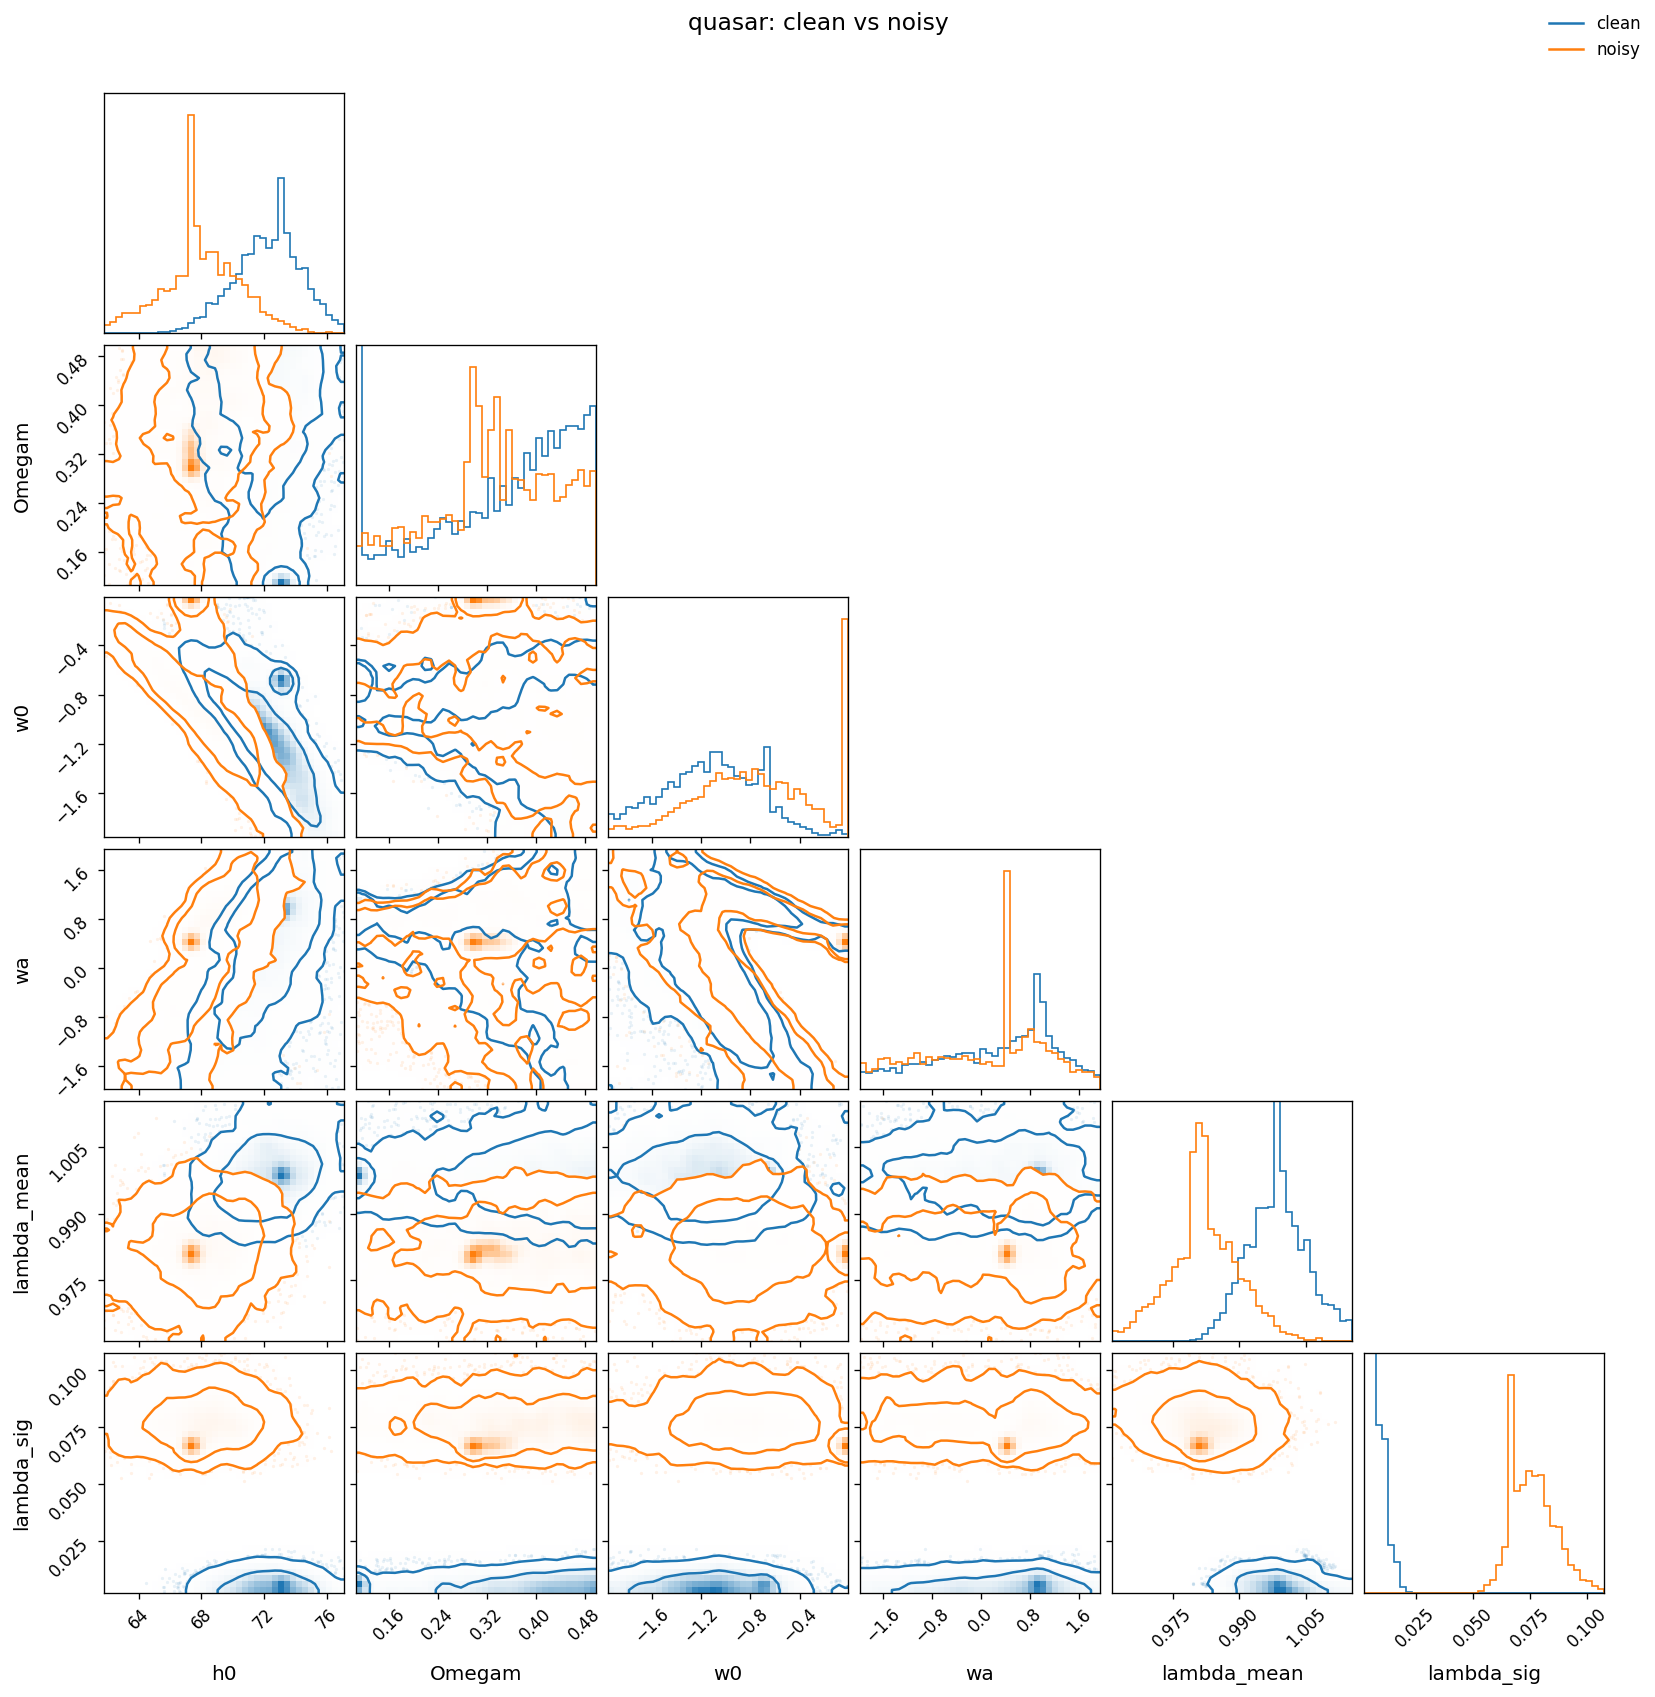

[PAIR] sne: clean vs noisy | params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | clean N=4000 | noisy N=4000


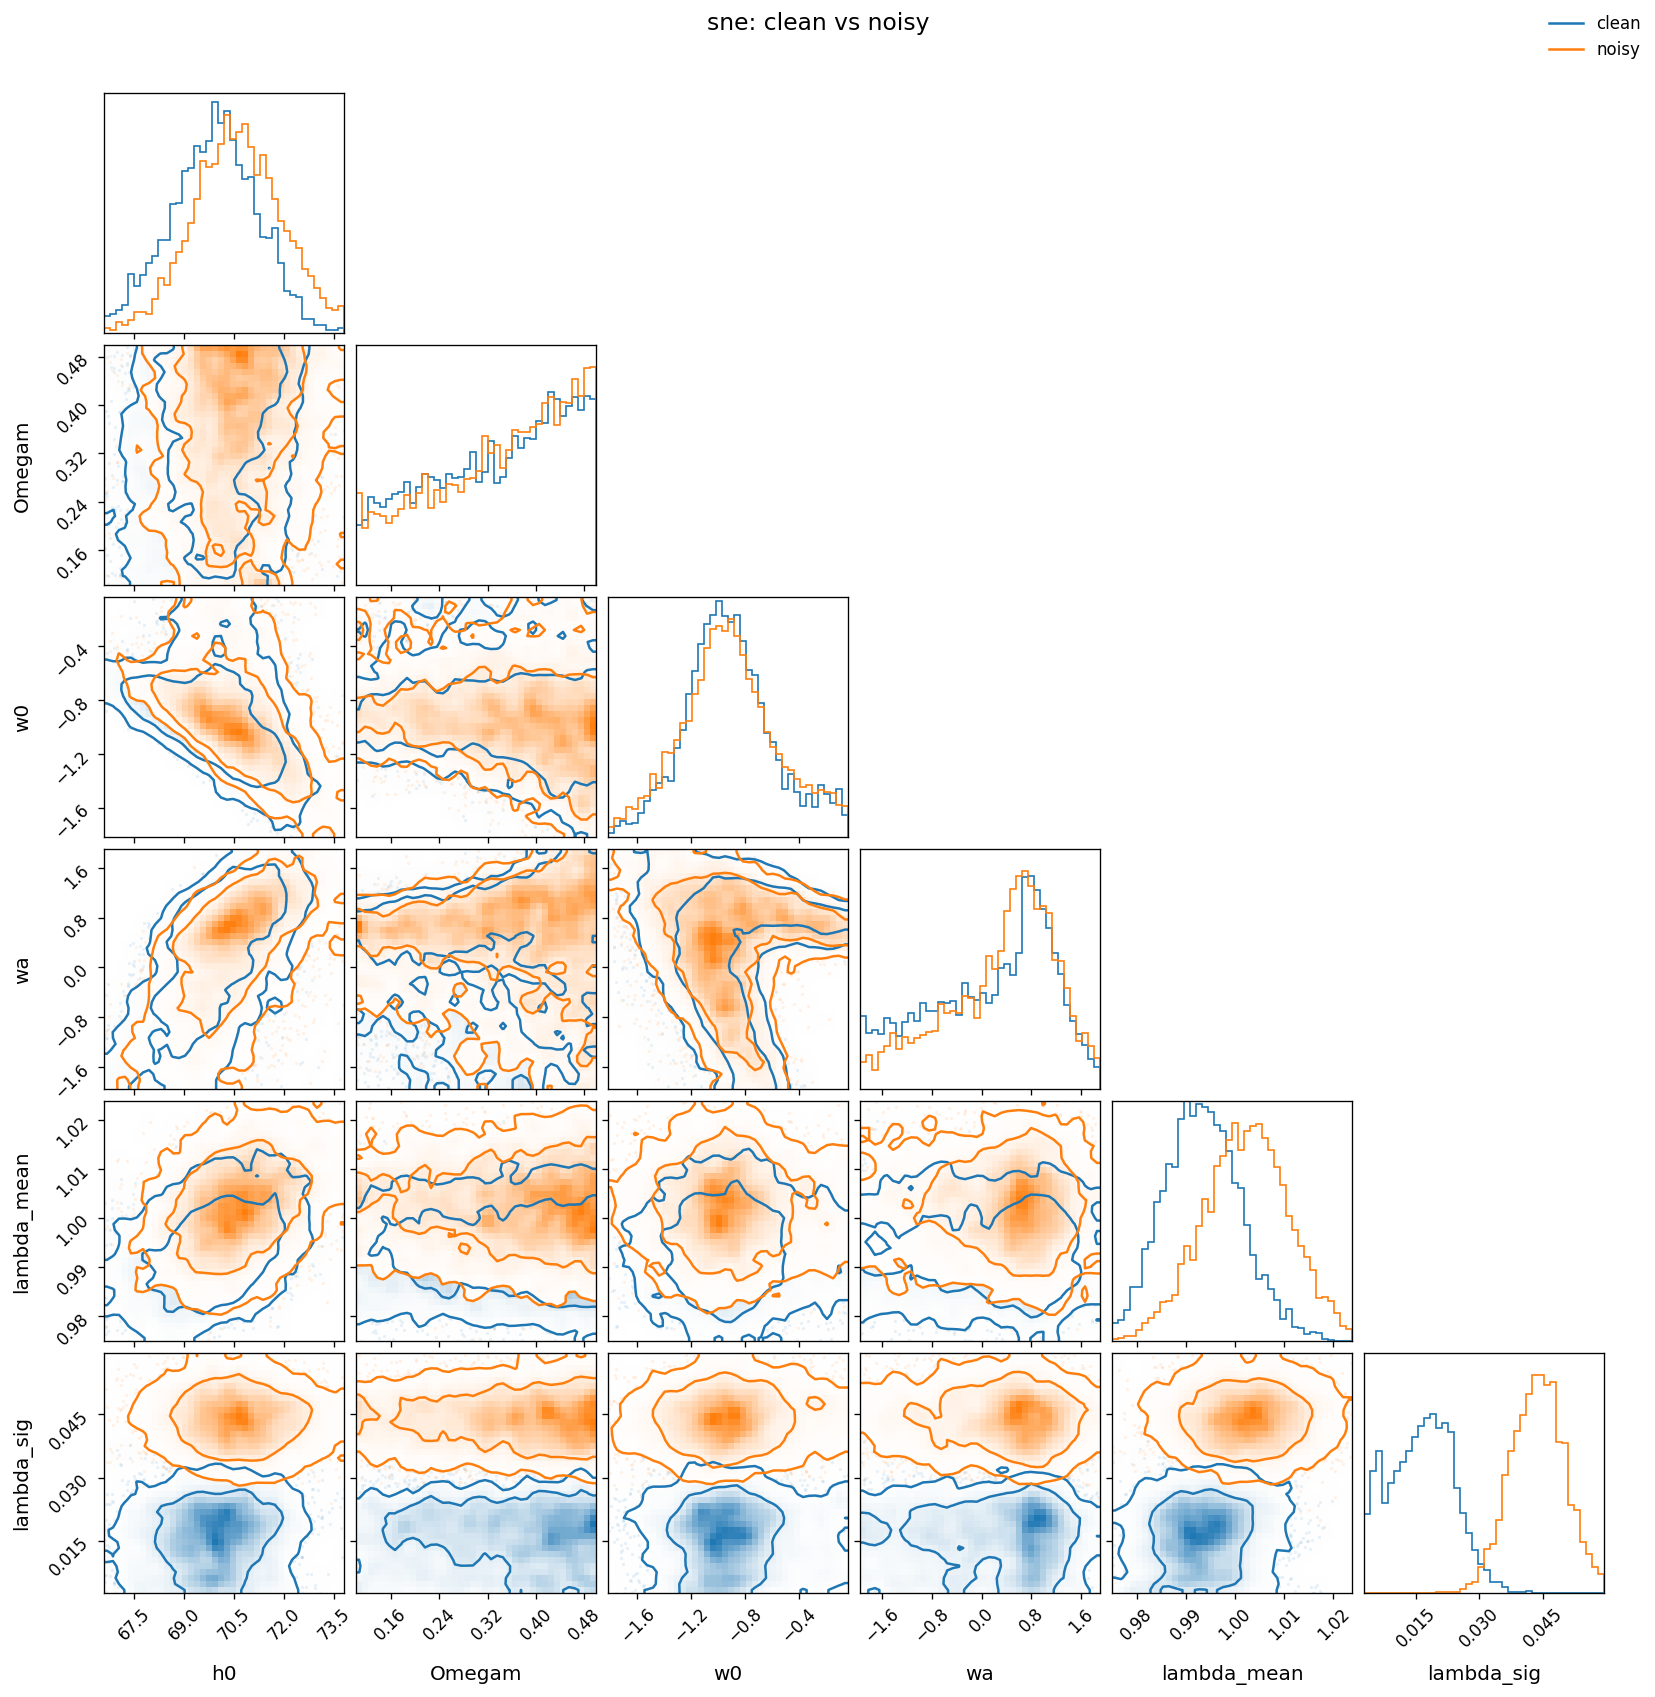

[PAIR] joint: clean vs noisy | params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | clean N=6000 | noisy N=6000


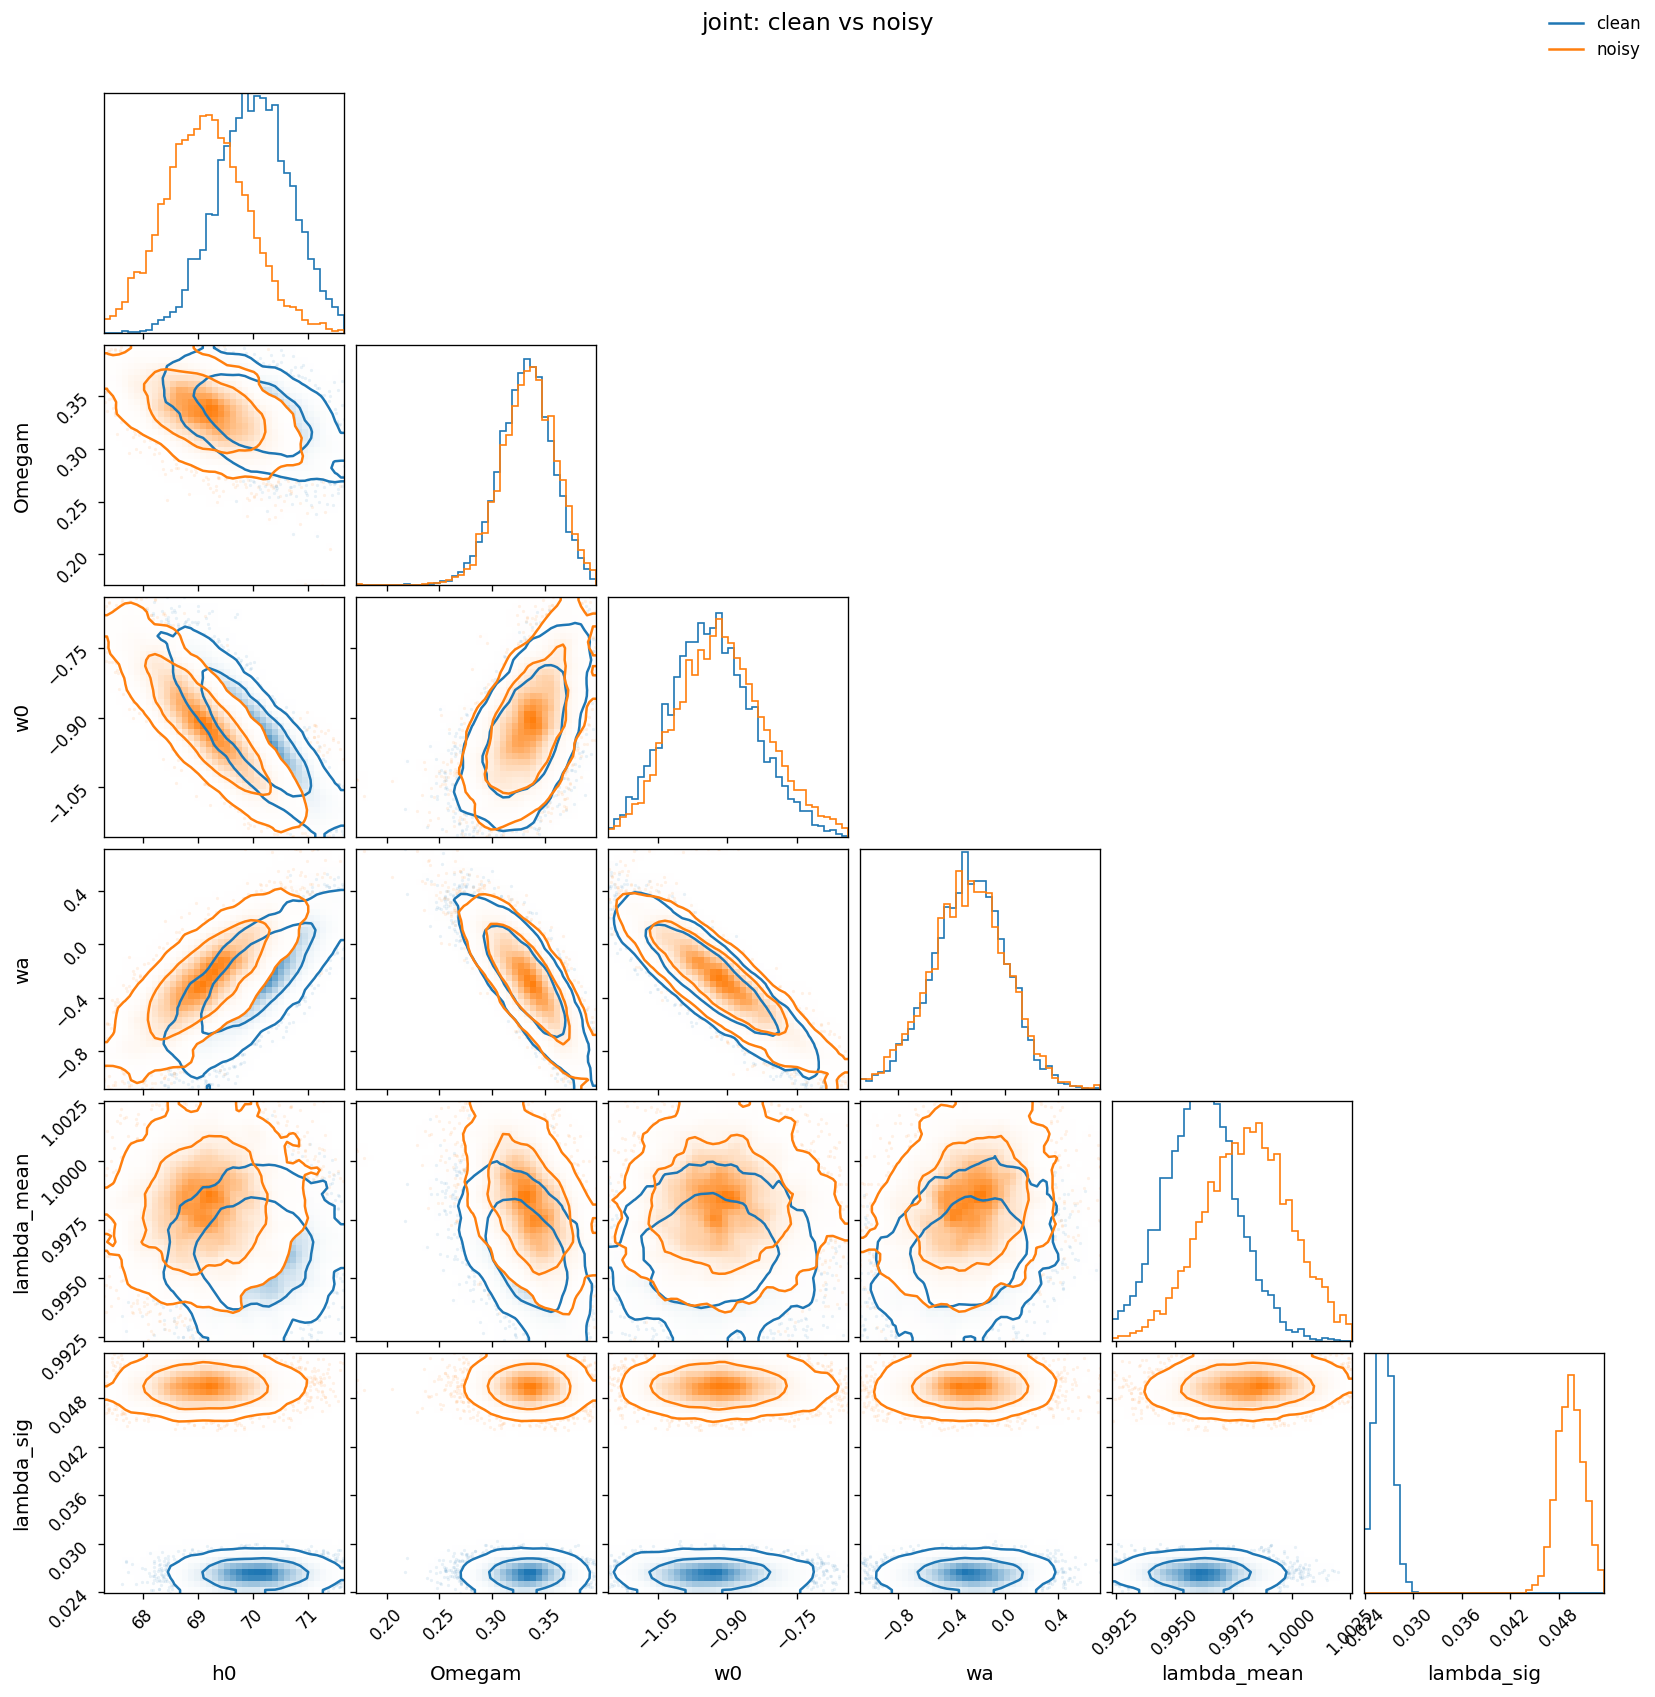

[AGG CLEAN] params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | dspl_clean N=6000 | lens_kin_clean N=6000 | quasar_clean N=4000 | sne_clean N=4000


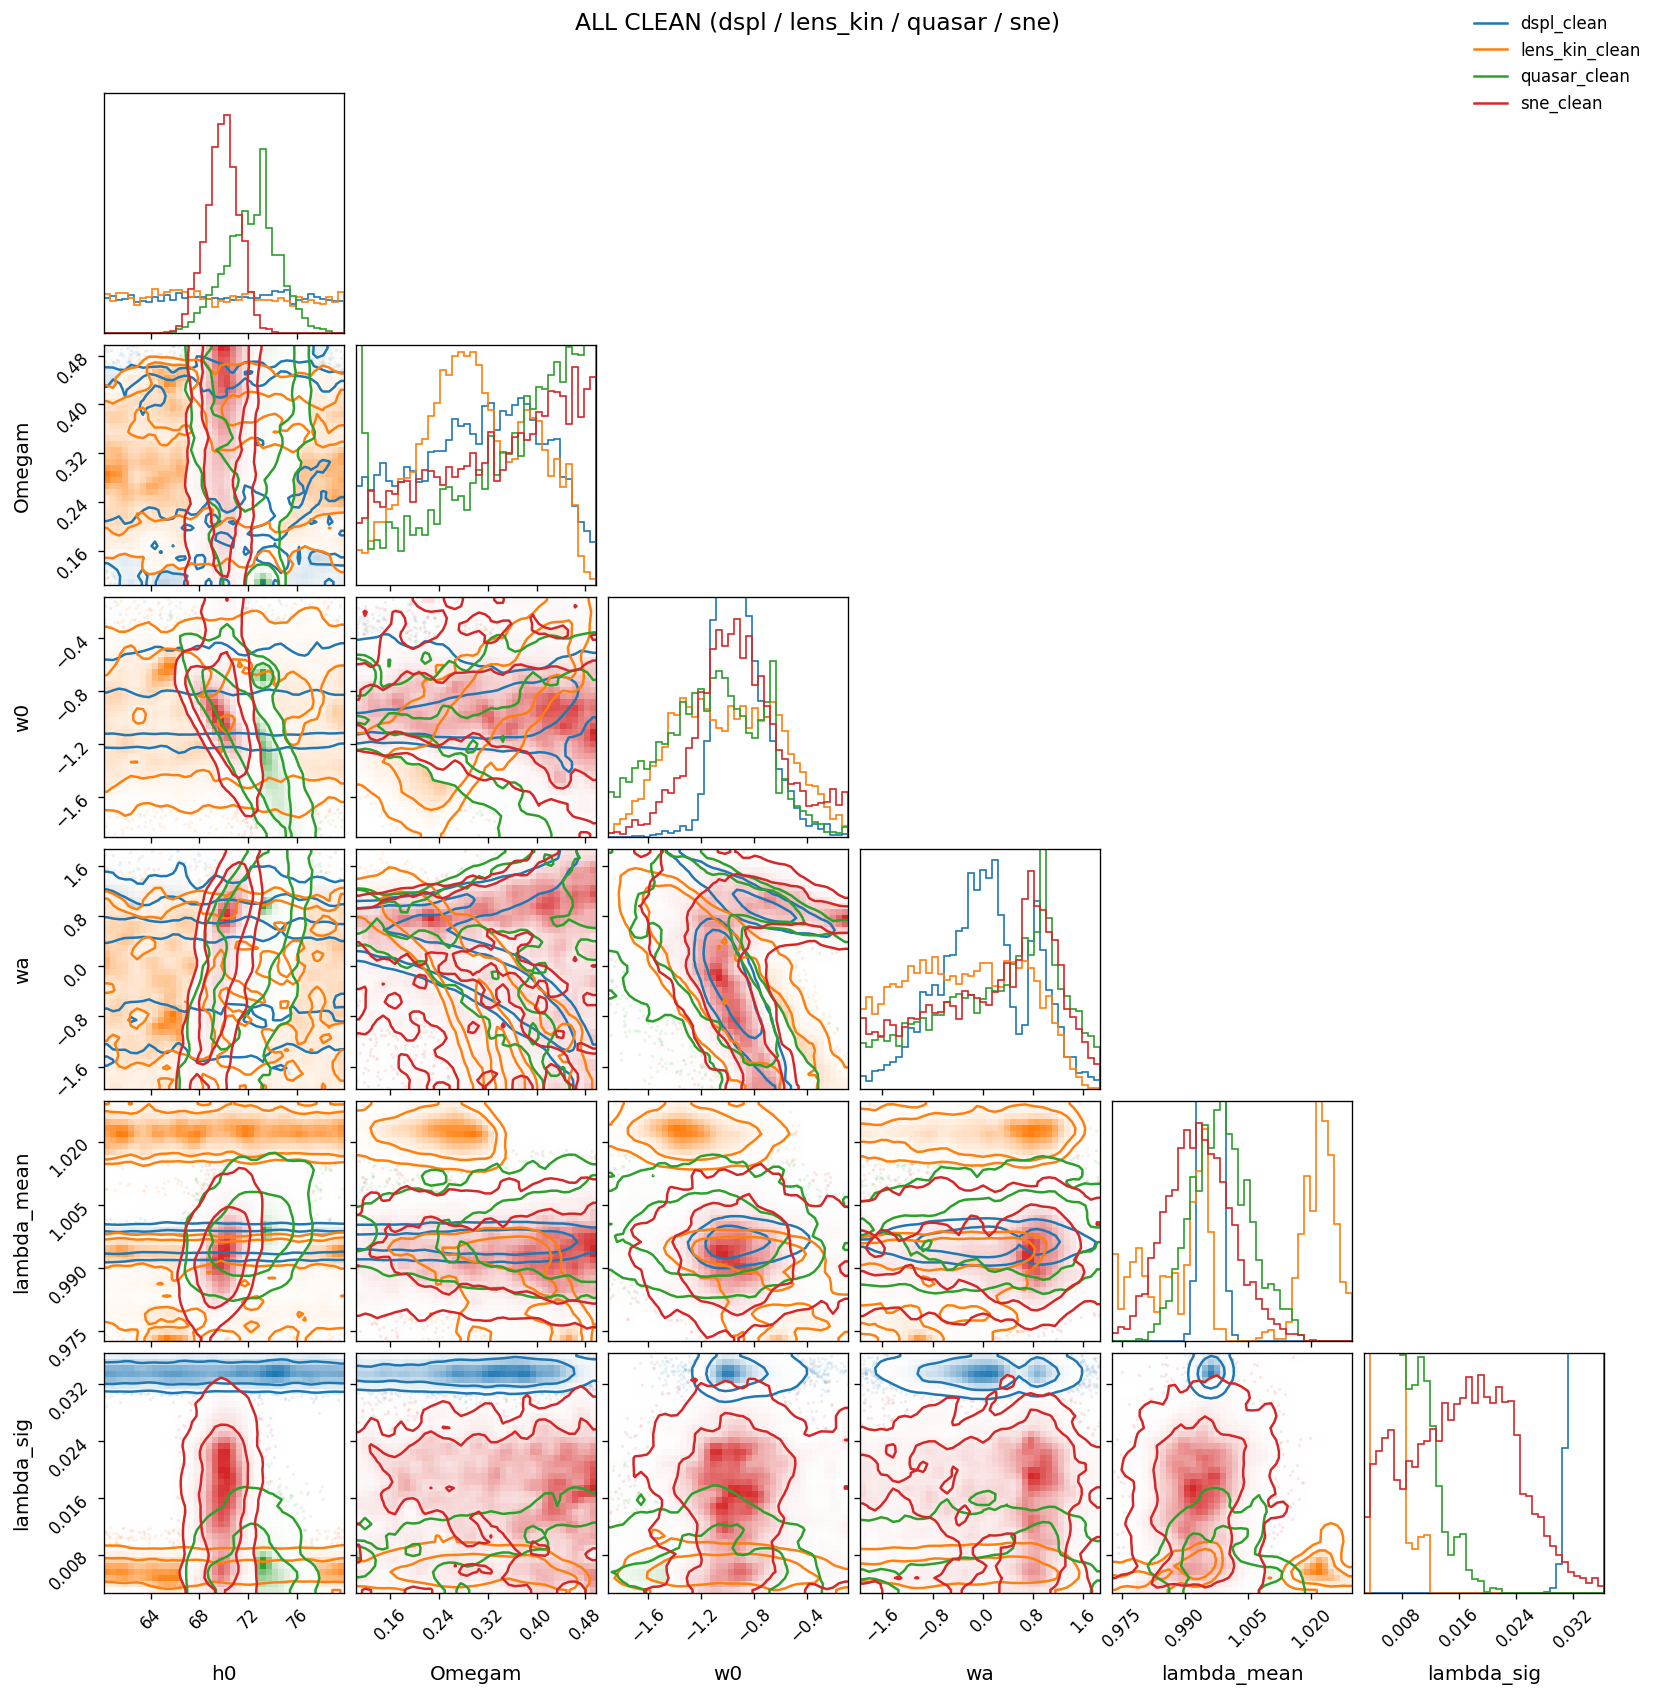

[AGG NOISY] params=['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sig'] | dspl_noisy N=6000 | lens_kin_noisy N=6000 | quasar_noisy N=4000 | sne_noisy N=4000


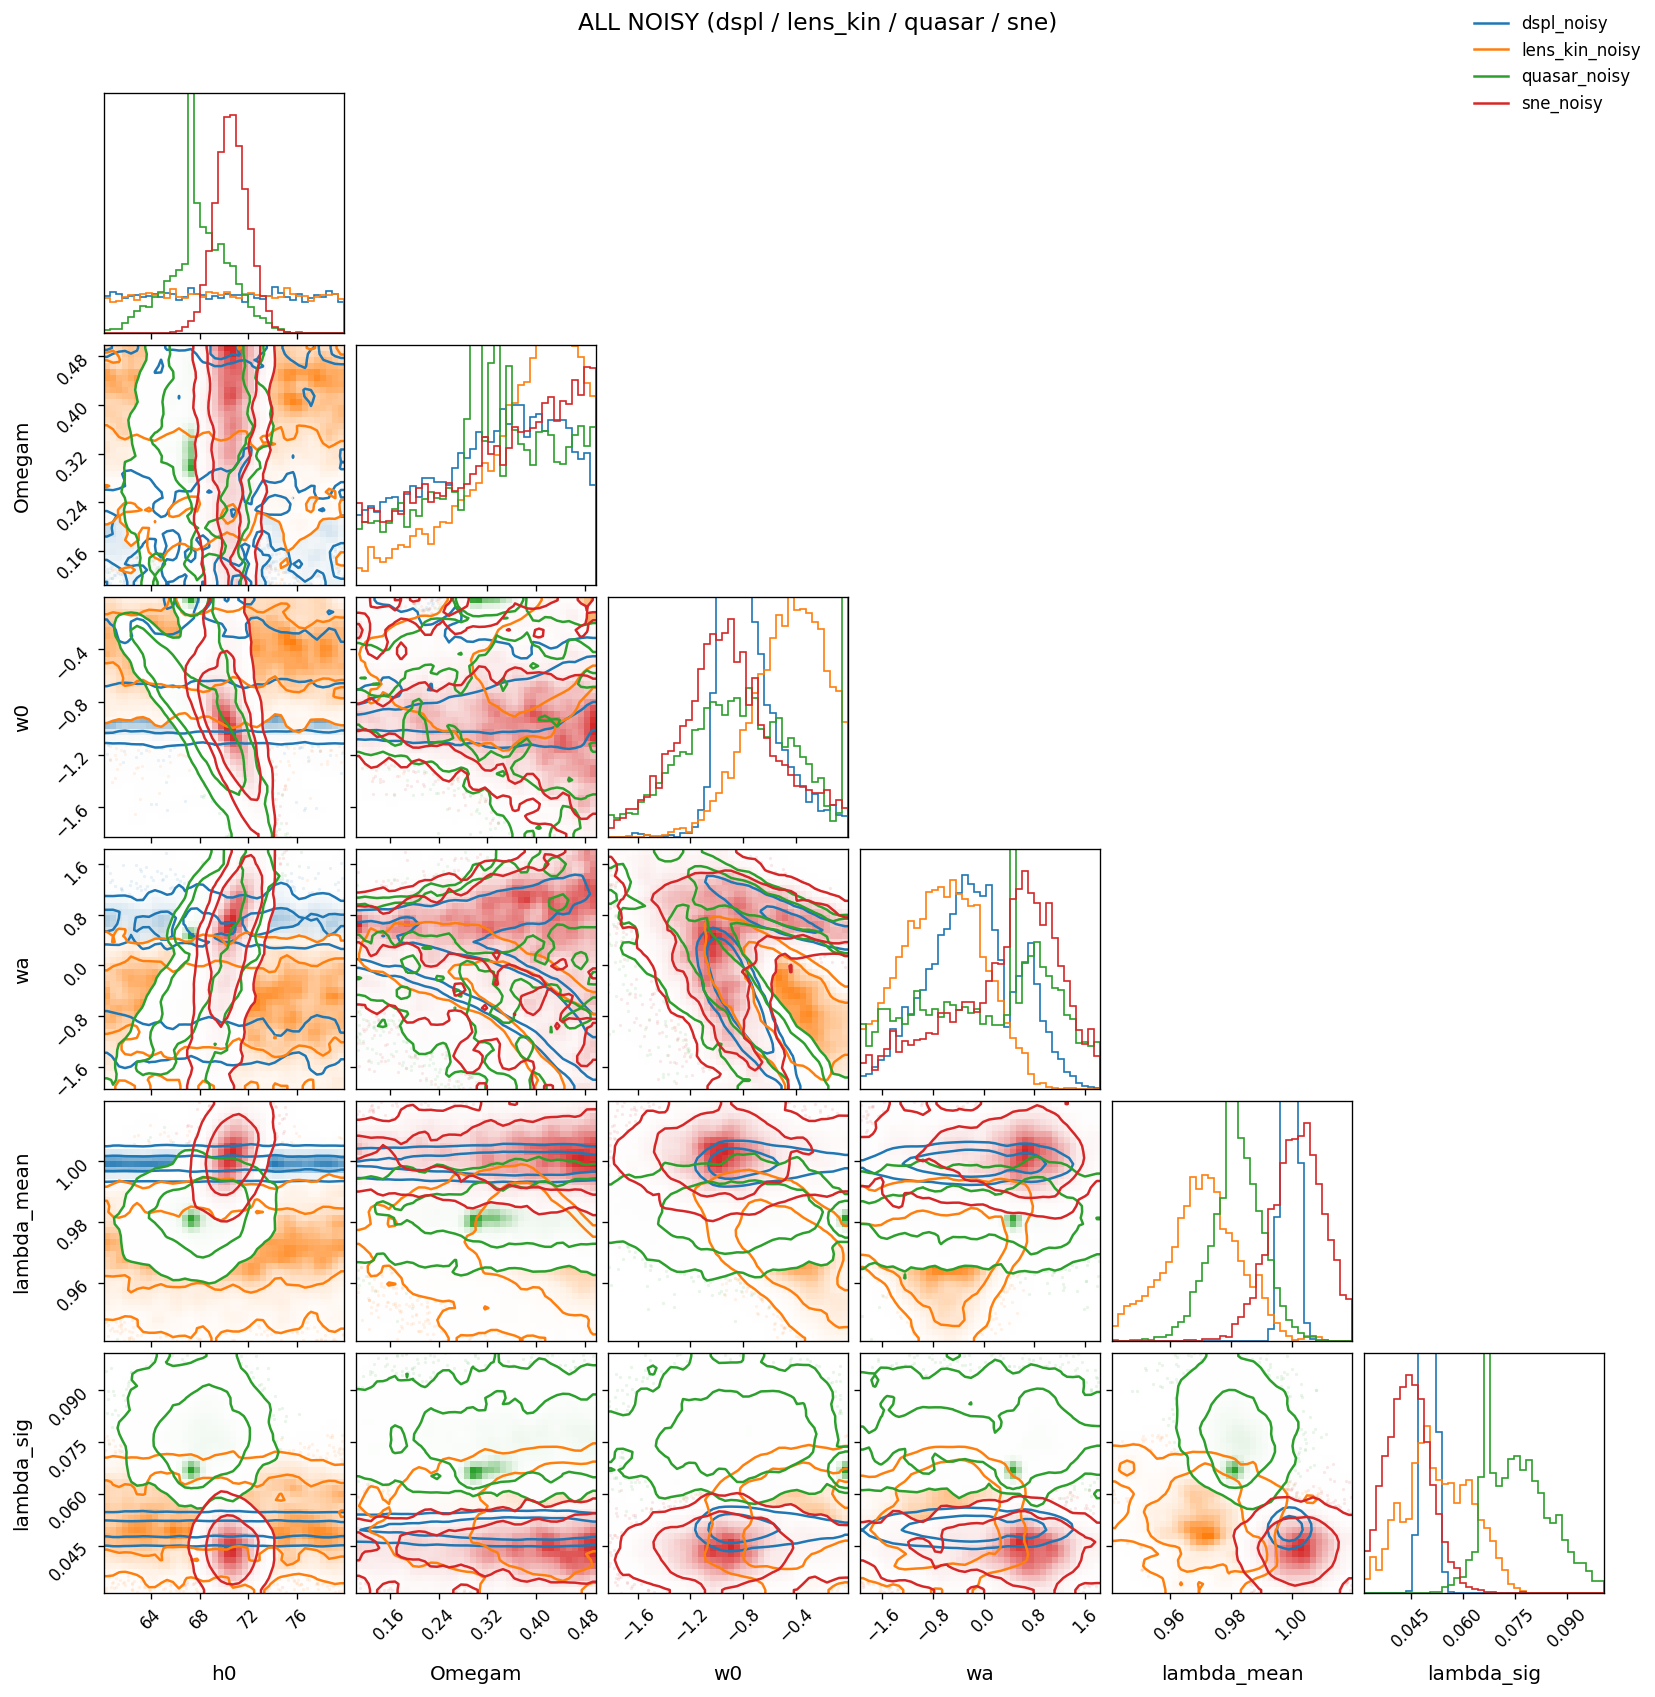

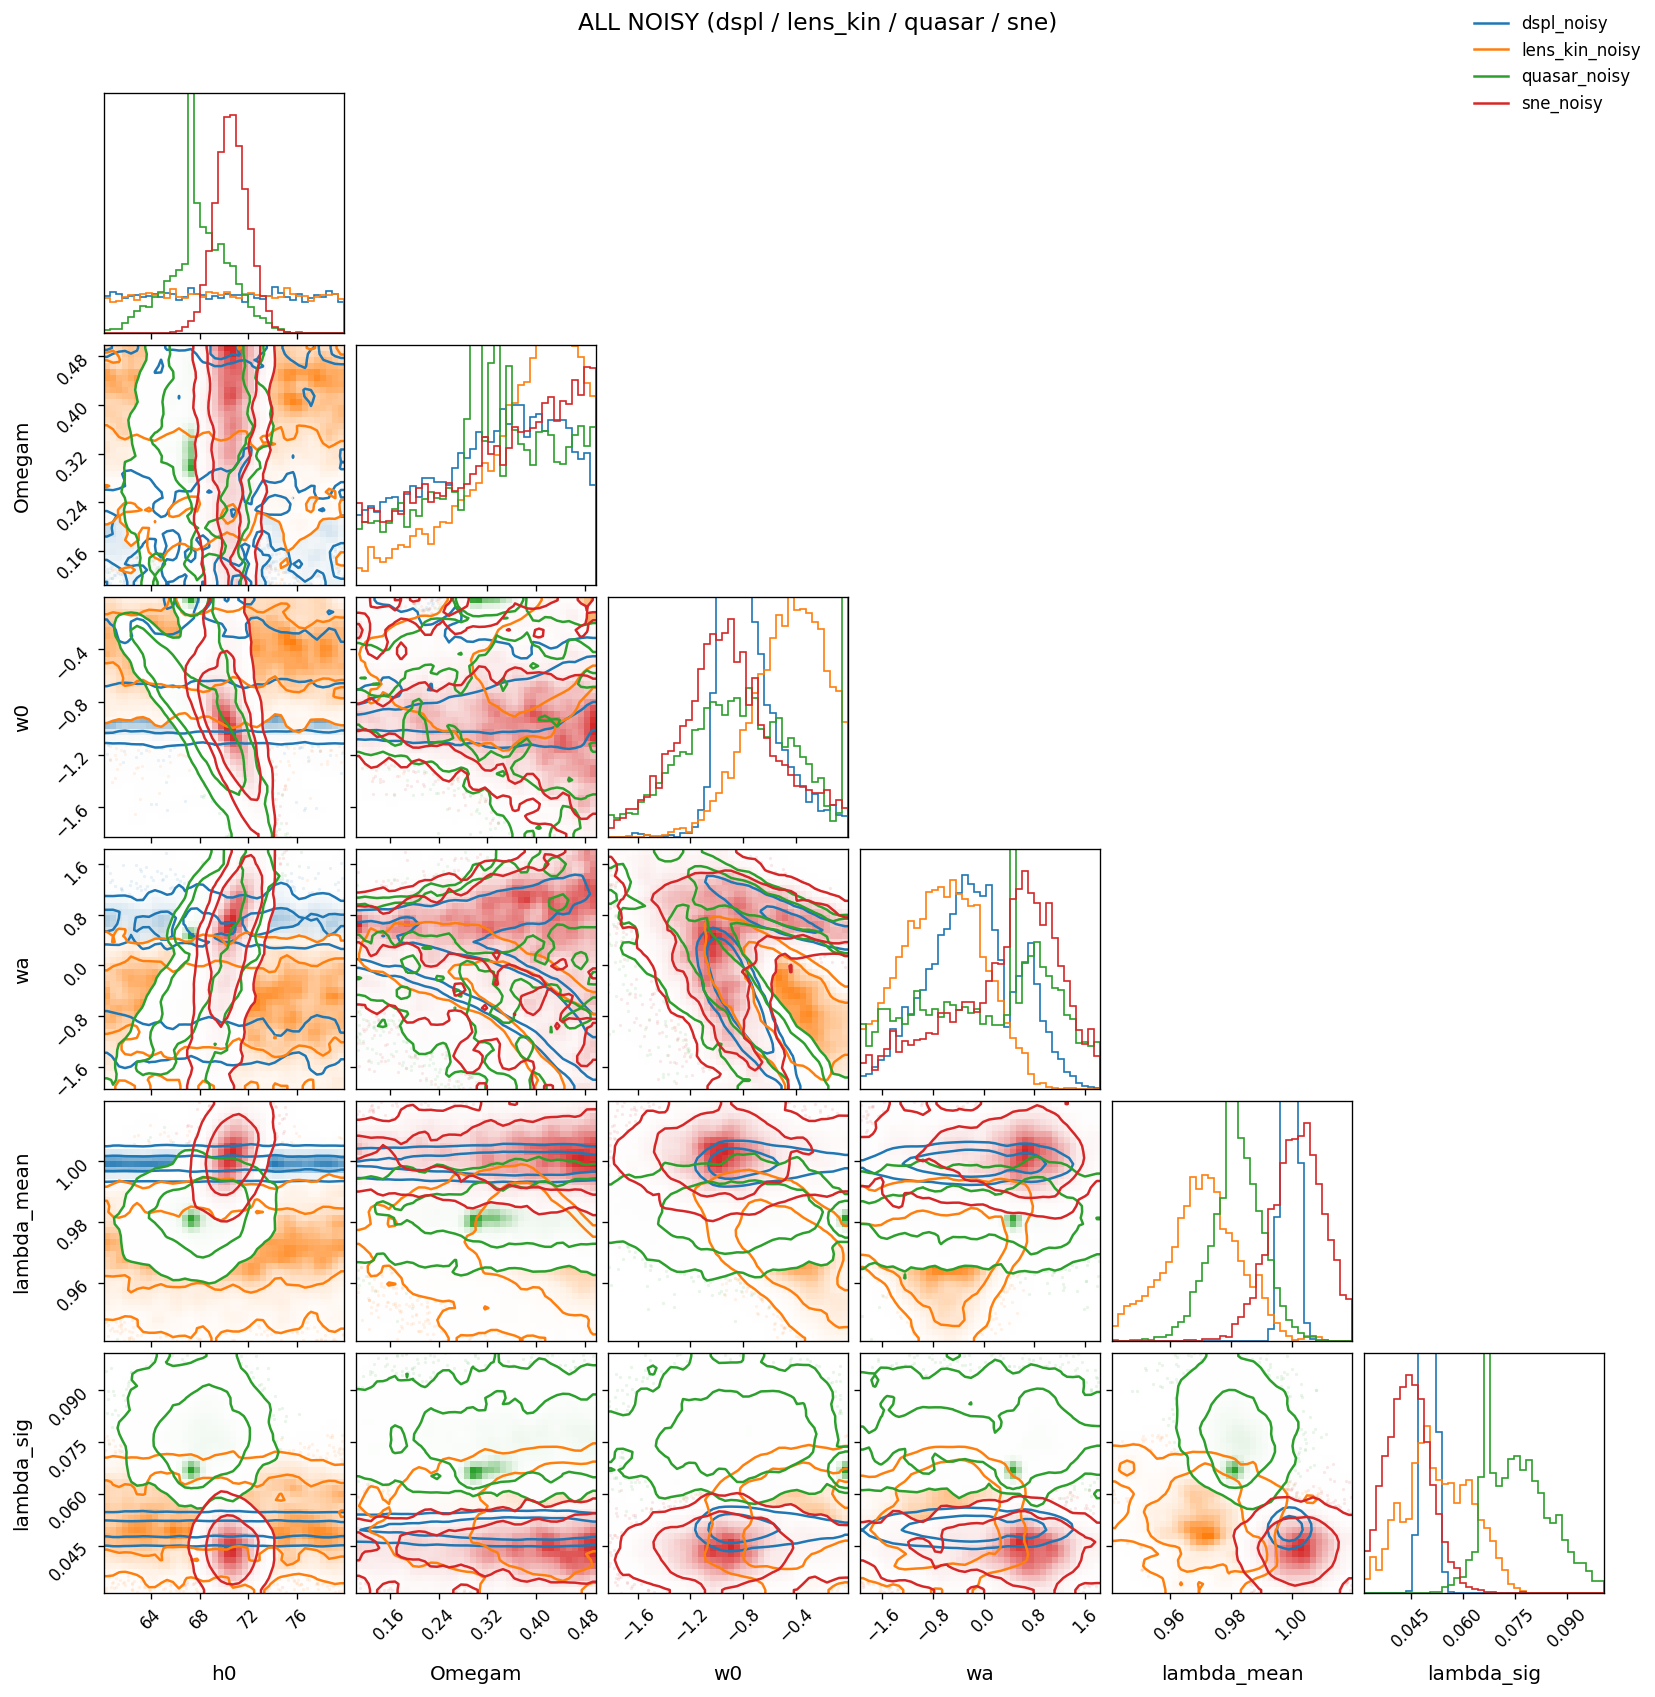

In [13]:
# Jupyter Cell (single block): generate ALL corner plots
# - Pair plots: clean vs noisy overlay (different colors) for dspl, lens_kin, quasar, sne, joint (if files exist)
# - Aggregate plots: ALL clean in ONE corner (4 different colors: dspl/lens_kin/quasar/sne)
#                    ALL noisy in ONE corner (4 different colors: dspl/lens_kin/quasar/sne)
#
# Params target: ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sig"]
# Auto-handling:
#   - Pair plots use intersection(clean,noisy) so dspl/lens_kin will drop h0 automatically.
#   - Aggregate plots use intersection across the 4 datasets, so h0 will be dropped automatically.

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import arviz as az
import corner
import matplotlib.lines as mlines

plt.rcParams["figure.dpi"] = 120

# -----------------------
# USER SETTINGS
# -----------------------
BASE_DIR = Path("/mnt/lustre/tianli/LensedUniverse_result")  # <- change if needed
DESIRED_PARAMS = ["h0", "Omegam", "w0", "wa", "lambda_mean", "lambda_sig"]

MAX_SAMPLES_PAIR = 50000          # per file for pair plots
MAX_SAMPLES_AGG_PER_FILE = 30000  # per file for aggregate plots
Q_RANGE = (0.005, 0.995)          # quantile range for corner axis limits

PRIMARY_DATASETS = ["dspl", "lens_kin", "quasar", "sne"]  # aggregate uses these 4 (as you requested)
EXTRA_DATASETS = ["joint"]                                # also make pair plot for joint

# Colors (matplotlib defaults)
PAIR_COLORS = {"clean": "C0", "noisy": "C1"}
AGG_COLORS_PRIMARY = {"dspl":"C0", "lens_kin":"C1", "quasar":"C2", "sne":"C3", "joint":"C4"}

# -----------------------
# Helper functions
# -----------------------
ALIASES = {
    "h0": ["h0", "H0"],
    "Omegam": ["Omegam", "omega_m", "Omega_m", "OmegaM", "omegam", "OmegaM0"],
    "w0": ["w0", "w_0", "W0"],
    "wa": ["wa", "w_a", "WA"],
    "lambda_mean": ["lambda_mean", "lambda_mu", "lambdaMean", "lambda_mean_"],
    "lambda_sig": ["lambda_sig", "lambda_sigma", "lambda_std", "lambdaSig", "lambda_sig_"],
}

def _open_as_posterior_xr(path: Path) -> xr.Dataset:
    """Prefer ArviZ posterior group; fallback to plain xarray Dataset."""
    path = Path(path)
    try:
        idata = az.from_netcdf(path)
        if getattr(idata, "posterior", None) is not None:
            return idata.posterior
    except Exception:
        pass
    return xr.open_dataset(path)

def _resolve_var_name(ds: xr.Dataset, canonical: str) -> str | None:
    """Find variable in ds (data_vars OR coords) matching canonical or aliases."""
    cand_list = ALIASES.get(canonical, [canonical])

    # Search data_vars first, then all variables (includes coords)
    var_lists = [list(ds.data_vars.keys()), list(ds.variables.keys())]

    for vars_ in var_lists:
        # exact match
        for c in cand_list:
            if c in vars_:
                return c
        # case-insensitive match
        lower_map = {v.lower(): v for v in vars_}
        for c in cand_list:
            if c.lower() in lower_map:
                return lower_map[c.lower()]

    return None

def available_params(ds: xr.Dataset, desired: list[str]) -> list[str]:
    return [p for p in desired if _resolve_var_name(ds, p) is not None]

def extract_samples(ds: xr.Dataset, params: list[str], max_samples: int = 50000, seed: int = 0):
    """
    Return X (N,D) and labels.
    Assumes each param is scalar per draw. Flattens chain/draw/whatever into 1D samples.
    """
    cols, labels = [], []
    for p in params:
        vname = _resolve_var_name(ds, p)
        if vname is None:
            continue
        arr = np.asarray(ds[vname].values)

        # Allow shapes: (draw,), (chain,draw), (chain,draw,1) etc.
        if arr.ndim == 0:
            arr = arr.reshape(1)
        elif arr.ndim >= 3:
            tail = arr.shape[2:]
            if np.prod(tail) != 1:
                raise ValueError(f"Variable '{vname}' has unexpected shape {arr.shape} (expected scalar per draw).")
            arr = arr.reshape(arr.shape[0], arr.shape[1])

        arr = arr.reshape(-1)
        cols.append(arr)
        labels.append(p)

    if len(cols) == 0:
        raise ValueError("No parameters extracted; check variable names in the .nc files.")

    X = np.vstack(cols).T  # (N, D)

    if X.shape[0] > max_samples:
        rng = np.random.default_rng(seed)
        idx = rng.choice(X.shape[0], size=max_samples, replace=False)
        X = X[idx]

    return X, labels

def corner_ranges(*Xs, q=Q_RANGE):
    """Compute per-dimension ranges from combined samples."""
    X = np.vstack(Xs)
    lo = np.quantile(X, q[0], axis=0)
    hi = np.quantile(X, q[1], axis=0)
    return [(float(lo[i]), float(hi[i])) for i in range(X.shape[1])]

def corner_overlay_multi(X_list, labels, colors, legend_labels, title=""):
    """Overlay multiple posteriors in one corner plot."""
    ranges = corner_ranges(*X_list)

    fig = None
    for i, (X, c) in enumerate(zip(X_list, colors)):
        fig = corner.corner(
            X,
            fig=fig,
            labels=labels,
            range=ranges,
            color=c,
            bins=40,
            plot_density=True,
            plot_contours=True,
            fill_contours=False,
            levels=(0.68, 0.95),
            smooth=1.0,
            label_kwargs={"fontsize": 12},
            hist_kwargs={"density": True},
        )

    handles = [mlines.Line2D([], [], color=c, label=lab) for c, lab in zip(colors, legend_labels)]
    fig.legend(handles=handles, loc="upper right", frameon=False)

    if title:
        fig.suptitle(title, fontsize=14, y=1.02)

    plt.show()
    return fig

def corner_pair_clean_noisy(clean_path: Path, noisy_path: Path, title: str, seed: int = 0):
    """Single dataset: overlay clean vs noisy in one corner plot."""
    clean_ds = _open_as_posterior_xr(clean_path)
    noisy_ds = _open_as_posterior_xr(noisy_path)

    clean_avail = set(available_params(clean_ds, DESIRED_PARAMS))
    noisy_avail = set(available_params(noisy_ds, DESIRED_PARAMS))
    use_params = [p for p in DESIRED_PARAMS if (p in clean_avail and p in noisy_avail)]
    if len(use_params) == 0:
        raise ValueError(f"No shared params between {clean_path.name} and {noisy_path.name}")

    Xc, labels = extract_samples(clean_ds, use_params, max_samples=MAX_SAMPLES_PAIR, seed=seed)
    Xn, _      = extract_samples(noisy_ds, use_params, max_samples=MAX_SAMPLES_PAIR, seed=seed + 1)

    print(f"[PAIR] {title} | params={labels} | clean N={Xc.shape[0]} | noisy N={Xn.shape[0]}")

    corner_overlay_multi(
        [Xc, Xn],
        labels=labels,
        colors=[PAIR_COLORS["clean"], PAIR_COLORS["noisy"]],
        legend_labels=["clean", "noisy"],
        title=title,
    )

def build_paths(dataset: str):
    return (BASE_DIR / f"{dataset}_clean.nc", BASE_DIR / f"{dataset}_noisy.nc")

# -----------------------
# 1) Pair plots (clean vs noisy) — dspl/lens_kin/quasar/sne + joint
# -----------------------
all_for_pairs = PRIMARY_DATASETS + EXTRA_DATASETS
for i, dsname in enumerate(all_for_pairs, start=1):
    clean_path, noisy_path = build_paths(dsname)
    if clean_path.exists() and noisy_path.exists():
        corner_pair_clean_noisy(clean_path, noisy_path, title=f"{dsname}: clean vs noisy", seed=100 + i)
    else:
        print(f"[SKIP] pair plot for {dsname}: missing file(s):",
              f"{clean_path.name if not clean_path.exists() else ''}",
              f"{noisy_path.name if not noisy_path.exists() else ''}".strip())

# -----------------------
# 2) Aggregate plot: ALL clean (4 datasets, 4 colors) — dspl/lens_kin/quasar/sne
# -----------------------
clean_ds_objs = {}
for dsname in PRIMARY_DATASETS:
    p = BASE_DIR / f"{dsname}_clean.nc"
    if not p.exists():
        raise FileNotFoundError(f"Missing {p}")
    clean_ds_objs[dsname] = _open_as_posterior_xr(p)

# intersection of available params across the 4 clean datasets
params_sets = [set(available_params(ds, DESIRED_PARAMS)) for ds in clean_ds_objs.values()]
use_params_clean_all = [p for p in DESIRED_PARAMS if all(p in s for s in params_sets)]
if len(use_params_clean_all) == 0:
    raise ValueError("No common parameters across ALL 4 clean datasets.")

X_list = []
labels_common = None
legend_labs = []
colors = []
for j, dsname in enumerate(PRIMARY_DATASETS):
    X, labels = extract_samples(clean_ds_objs[dsname], use_params_clean_all,
                                max_samples=MAX_SAMPLES_AGG_PER_FILE, seed=200 + j)
    X_list.append(X)
    labels_common = labels
    legend_labs.append(f"{dsname}_clean")
    colors.append(AGG_COLORS_PRIMARY[dsname])

print(f"[AGG CLEAN] params={labels_common} | " +
      " | ".join([f"{lab} N={X.shape[0]}" for lab, X in zip(legend_labs, X_list)]))

corner_overlay_multi(
    X_list,
    labels=labels_common,
    colors=colors,
    legend_labels=legend_labs,
    title="ALL CLEAN (dspl / lens_kin / quasar / sne)",
)

# -----------------------
# 3) Aggregate plot: ALL noisy (4 datasets, 4 colors) — dspl/lens_kin/quasar/sne
# -----------------------
noisy_ds_objs = {}
for dsname in PRIMARY_DATASETS:
    p = BASE_DIR / f"{dsname}_noisy.nc"
    if not p.exists():
        raise FileNotFoundError(f"Missing {p}")
    noisy_ds_objs[dsname] = _open_as_posterior_xr(p)

params_sets = [set(available_params(ds, DESIRED_PARAMS)) for ds in noisy_ds_objs.values()]
use_params_noisy_all = [p for p in DESIRED_PARAMS if all(p in s for s in params_sets)]
if len(use_params_noisy_all) == 0:
    raise ValueError("No common parameters across ALL 4 noisy datasets.")

X_list = []
labels_common = None
legend_labs = []
colors = []
for j, dsname in enumerate(PRIMARY_DATASETS):
    X, labels = extract_samples(noisy_ds_objs[dsname], use_params_noisy_all,
                                max_samples=MAX_SAMPLES_AGG_PER_FILE, seed=300 + j)
    X_list.append(X)
    labels_common = labels
    legend_labs.append(f"{dsname}_noisy")
    colors.append(AGG_COLORS_PRIMARY[dsname])

print(f"[AGG NOISY] params={labels_common} | " +
      " | ".join([f"{lab} N={X.shape[0]}" for lab, X in zip(legend_labs, X_list)]))

corner_overlay_multi(
    X_list,
    labels=labels_common,
    colors=colors,
    legend_labels=legend_labs,
    title="ALL NOISY (dspl / lens_kin / quasar / sne)",
)
